# INF8825 - Travail pratique 2
___

Claudia Onorato (1845448)

Les deux parties de ce travail a été réalisé avec William Harvey (1851388).

## Partie I
____

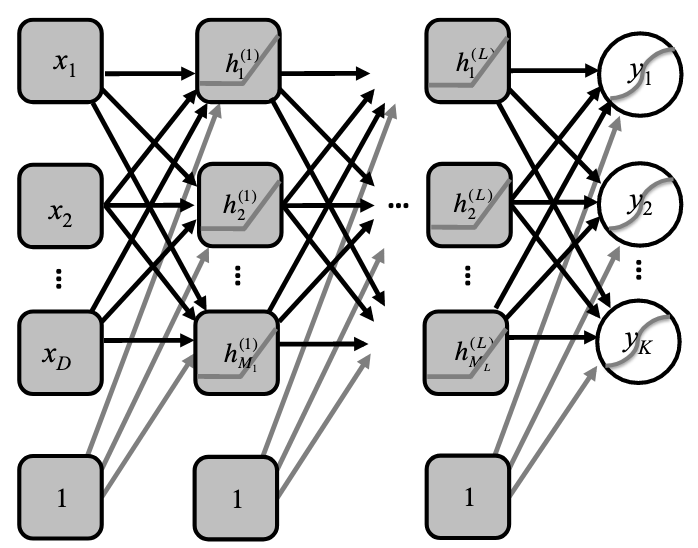

### a) Pseudocode de l'algorithme de rétropropagation
___

L'algorithme de rétropropagation se base sur le calcul de gradients afin d'ajuster tous les poids du modèle en minimisant la fonction de coût. 

La fonction de coût correspond à la cross-entropy lié au softmax: $$L = -\sum_{i=1}^{K} y_i \log(f_i)$$

Comme on peut voir ci-dessous dans l'arbre de dépendance des la fonction de coût, celle-ci dépend directement de la fonction d'activation de la dernière couche. Celle-ci est softmax:

$$f_k = \frac{exp(a_k^{(L+1)})}{\sum_{c=1}^K exp{(a_c^{(L+1)})}}$$

Le résultat de la préactivation équivaut quant à elle à $a^{(L+1)} = \theta^{(L+1)}\hat{h}^{(L)}$.

Par la suite, le calcul de l'activation des couches cachées se font par la fonction `ReLU`: $h^{(L)} = ReLU(a^{(L)})$. 

Afin de bien comprendre les calculs des gradients, il est important de voir la dépendance entre les différentes fonctions et couches. Ci-dessous, nous avons, à la gauche, les dépendances de la dernière couche, suivant la notation de l'énoncé. Ensuite, une exemple d'une couche cachée au centre, puis la première couche à droite.


```
                      θ(L+1)   h(L)        θ(L)    h(L-1)          θ(1)     x 
                        ^       ^           ^       ^               ^       ^            
                        |       |           |       |               |       |        
                        +---+---+           +---+---+               +---+---+          
                            +                   |                       |                 
                          a(L+1)               a(L)        ...         a(1)                    
                            ^                   ^                       ^            
                            |                   |                       |            
                   y        f                   |                       |           
                   ^        ^                  h(L)                    h(1)      
                   |        |
                   +----+---+
                        |
                        +
                        L

```

Pour les calculs des gradients, observons d'abord la dernière couche. Nous allons utiliser la dérivation en chaîne:

$$\frac{\delta L}{\delta\theta^{(L+1)}} = \frac{\delta L}{\delta f} \frac{\delta f}{\delta a^{(L+1)}} \frac{\delta a^{(L+1)}}{\delta\theta^{(L+1)}} $$

$$\frac{\delta L}{\delta\theta^{(L+1)}} = -(y - f^{(L+1)}))\hat{h}^{(L)} = -\Delta^{(L+1)} \hat{h}^{(L)T}$$

Pour les poids des couches cachées, nous calculons les gradients de cette manière, en se basant sur les gradients des couches supérieures: 

$$\frac{\delta L}{\delta\theta^{(l)}} = -\Delta^{(l)} \frac{\delta a^{(l)}}{\delta\theta^{(l)}}$$

Où:

$$\Delta^{(l)} = \frac{\delta \hat{h}^{(l)}}{\delta a^{(l)}} \frac{\delta a^{(l+1)}}{\delta \hat{h}^{(l)}}\Delta^{(l+1)} = D^{(l)}\theta^{(l+1)}\Delta^{(l+1)}$$

et

$$\frac{\delta a^{(l)}}{\delta\theta^{(l)}} = \hat{h}^{(l-1)}$$

On a alors:

$$\frac{\delta L}{\delta\theta^{(l)}} = D^{(l)}\theta^{(l+1)}\Delta^{(l+1)}\hat{h}^{(l-1)}$$

Le calcul de la première couche se fait de la même manière, en remplaçant $\hat{h}^{(l-1)}$ par $\hat{x}$.

Nous pouvons alors formuler le pseudocode suivant:


```
Entrée:
    theta: 
        vecteurs de poids de dimension
            (M,D+1) pour la 1ere couche,
            (M,M+1) pour les L-1 autres couches cachées et
            (K,M+1) pour la L+1 dernière couche;
    f:
        valeurs d'activation softmax de dimension (K,1)        
    h:
        1 vecteur des valeurs d'entrée de taille (D + 1,1), auxquels on concatène un 1 (pour le biais)
            suivi de
        L vecteurs d'activation de dimension (M + 1,1), auxquels on concatène un 1 (pour le biais).
    a:
        L vecteurs de valeurs de préactivation (M,1)
        1 vecteur de préactivation de taille (K,1) pour la dernière couche
    y:
        One-hot vecteur de la valeur attendue de l'observation de taille (K,1)

Sortie:
    gradients:
        vecteurs de gradients de dimensions
            (M,D+1) pour la 1ere couche,
            (M,M+1) pour les L-1 autres couches cachées et
            (K,M+1) pour la L+1 dernière couche;

Procédure:

// 1. Calcul du gradient pour la dernière couche

current_delta = (y - f)
grads[L+1] = - current_delta * h[L]
previous_delta = current_delta

// 2. On calcule les gradients de l'avant dernière à la première couche
Pour chaque couche l de L à 1:
    
    // 2.1 On calcule la vecteur d qui contient les éléments de la diagonale de D
    //     Contient la dérivée de la fonction d'activation ReLU en fonction de a
    d = [1 if a_element > 0 for a_element in a[l] else 0]
    
    // 2.2 On calcule le delta pour la couche courante
    current_delta = d * (theta[l+1] * previous_delta)
    
    // 2.3 On calcule les gradients pour la couche courante
    grads[l] = - current_delta * h[l-1]
    
    // 2.4 On sauvegarde le delta de la couche courante pour la calcul de la couche (l-1).
    previous_delta = current_delta
    
Retourner grads
```

### b) Implémentation avec et sans Pytorch et comparaison
___

#### 0. Chargement du jeu de données
___

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST

In [16]:
train_set = FashionMNIST(
    root = './data/train-FashionMNIST',
    train = True,
    download = True
)

test_set = FashionMNIST(
    root = './data/test-FashionMNIST',
    train = False,
    download = True
)

In [46]:
train_set.train_data.shape

/Users/claudiaonorato/miniconda3/envs/py3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [45]:
train_set.train_labels.shape

/Users/claudiaonorato/miniconda3/envs/py3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000])

Expected image is Trouser


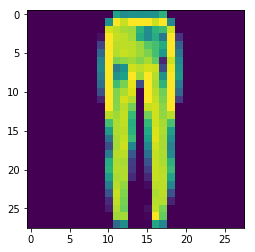

In [155]:
TRAIN_EXAMPLE = 4040
print(f"Expected image is {train_set.classes[train_set.train_labels[TRAIN_EXAMPLE]]}")
plt.imshow(train_set.train_data[TRAIN_EXAMPLE].numpy())

In [32]:
test_set.data.shape

torch.Size([10000, 28, 28])

Expected image is Trouser


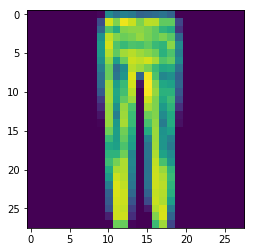

In [70]:
TEST_EXAMPLE = 4039
print(f"Expected image is {test_set.classes[test_set.test_labels[TEST_EXAMPLE]]}")
plt.imshow(test_set.test_data[TEST_EXAMPLE].numpy())

#### 1. Implémentation sans Pytorch
___

Lors de l'implémentation à la main du réseau de neurones, j'ai consulté [cet article](https://medium.com/@a.mirzaei69/implement-a-neural-network-from-scratch-with-python-numpy-backpropagation-e82b70caa9bb) qui monte un réseau de neurones ayant seulement une couche cachée et utilisant les fonctions d'activation sigmoid.

In [211]:
class HandmadeNetwork():
    
    def __init__(self, nb_hidden_layers, nb_inputs=784, nb_units_per_layer=300, nb_class=10):
        self.nb_units_per_layers = [nb_inputs] + [nb_units_per_layer] * nb_hidden_layers + [nb_class]
        self.theta = []
        
        for i in range(len(self.nb_units_per_layers)-1):
            print(f"{i}th layer: {self.nb_units_per_layers[i]+1} -> {self.nb_units_per_layers[i+1]}")
            self.theta.append(
                np.random.randn(
                    self.nb_units_per_layers[i+1], 
                    self.nb_units_per_layers[i] + 1
                ))

        print(f"Number of weight vectors: {len(self.theta)}")
        print(f"Number of units per layer: {self.nb_units_per_layers}")
        
    
    def train(self, x, y, batch_size=10, epochs=100, lr = 0.01):
        """
        Updates weights and biases in theta matrix according to this training set
        
        x: inputs of size (nb_inputs=784,)
        y: one-hot encoded vector of size (nb_class=10,)
        batch_size: nb of observations to include in a batch
        epochs: nb of iteration of training over the set
        lr: learning rate
        """
        for e in range(epochs): 
            print(e, " epoch")
            i=0
            while(i<len(y)):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]
    
                z_s, a_s = self._feedforward(x_batch)
                dw, db = self._backpropagation(y_batch, z_s, a_s)

                self.weights = [w+lr*dweight for w,dweight in  zip(self.weights, dw)]
                self.biases = [w+lr*dbias for w,dbias in  zip(self.biases, db)]
    
                print("loss = {}".format(np.linalg.norm(a_s[-1]-y_batch) ))
                
                i += batch_size

    
    def _feedforward(self, x):
        """
        Returns the preactivation and activation values for each layers after forwarding one observation
        
        a_s: (avant z_s) preactivation values for each layers and each units
            ** pas de +1 pour le biais dans les dimensions **
        h_s: (avant a_s) activation values for each layers and each units
            Note: last h values corresponds to the activation values f associated with softmax.
            Note: first h values corresponds to the activation values of the input layer, whereas the input x.
            ** pas de +1 pour le biais dans les dimensions **

        """
        h = np.copy(x)
        a_s = []
        h_s = [h]
        
        for i in range(len(self.theta)):
            h_hat = self.get_h_hat(h)
            print("h_hat ", h_hat.shape)
            print("theta[i] ", self.theta[i].shape)
            a = self.theta[i].dot(h_hat)
            print("a ", a.shape)
            a_s.append(a)
            
            h = self.relu(a)
            h_s.append(h)
            print("h ", a.shape)

        return a_s, h_s
    
    
    def _backpropagation(self,y, a_s, h_s):
        """
        Returns the gradients for each layers for one observation
        
        Input:
            y: one-hot encoded labels
            a_s: (avant z_s) preactivation values for each layers and each units
                ** pas de +1 pour le biais dans les dimensions **
            h_s: (avant a_s) activation values for each layers and each units
                Note: last h values corresponds to the activation values f associated with softmax.
                Note: first h values corresponds to the activation values of the input layer, whereas the input x.
                ** pas de +1 pour le biais dans les dimensions **
        Returns:
            dtheta: gradient for each weight and biases
        """

#         dw = []  # dL/dtheta
# #         db = []  # dC/dB
#         deltas = [None] * len(self.weights)  # delta = dC/dZ  known as error for each layer
#         # insert the last layer error
#         deltas[-1] = ((y-a_s[-1])*(self.getDerivitiveActivationFunction(self.activations[-1]))(z_s[-1]))
#         # Perform BackPropagation
#         for i in reversed(range(len(deltas)-1)):
#             deltas[i] = self.weights[i+1].T.dot(deltas[i+1])*(self.getDerivitiveActivationFunction(self.activations[i])(z_s[i]))        
#         #a= [print(d.shape) for d in deltas]
#         batch_size = y.shape[1]
#         db = [d.dot(np.ones((batch_size,1)))/float(batch_size) for d in deltas]
#         dw = [d.dot(a_s[i].T)/float(batch_size) for i,d in enumerate(deltas)]
#         # return the derivitives respect to weight matrix and biases
#         return dw, db
        L = len(self.theta)-1

        gradiants = [None] * len(self.theta) # dC/dtheta
        deltas = [None] * len(self.theta)
        
        print("h_s len ",len(h_s))
        print("theta len ",len(self.theta))
        
        deltas[-1] = (y - h_s[-1]) # shape (10,) and (10,) -> (10,)
        gradiants[-1] = -np.outer(deltas[-1], self.get_h_hat(h_s[-2])) # shape (10,) and (301,) -> (10,301)
        print(gradiants[-1].shape)
        
        for l in range(L-1, -1, -1):
            print(l, "th layer")
            d = self.relu_differential(a_s[l])
            
            
        return
    
    """
        // 2.1 On calcule la vecteur d qui contient les éléments de la diagonale de D
    //     Contient la dérivée de la fonction d'activation ReLU en fonction de a
    d = [1 if a_element > 0 for a_element in a[l] else 0]
    
    // 2.2 On calcule le delta pour la couche courante
    current_delta = d * (theta[l+1] * previous_delta)
    
    // 2.3 On calcule les gradients pour la couche courante
    grads[l] = - current_delta * h[l-1]
    
    // 2.4 On sauvegarde le delta de la couche courante pour la calcul de la couche (l-1).
    previous_delta = current_delta
    """
        
        
    @staticmethod
    def relu(x):
        y = np.copy(x)
        y[y<0] = 0
        return y
     
    @staticmethod
    def relu_differential(x):
        y = np.copy(x)
        y[y>=0] = 1
        y[y<0] = 0
        return y
    
    @staticmethod
    def get_h_hat(h):
        return np.pad(h, (0,1), constant_values=1)

In [212]:
nn = HandmadeNetwork(nb_hidden_layers=2)

# X = 2*np.pi*np.random.rand(1000).reshape(1, -1)
# y = np.sin(X)

# nn.train(X, y, epochs=10000, batch_size=64, lr = .1)
# _, a_s = nn.feedforward(X)
# #print(y, X)
# plt.scatter(X.flatten(), y.flatten())
# plt.scatter(X.flatten(), a_s[-1].flatten())
# plt.show()

0th layer: 785 -> 300
1th layer: 301 -> 300
2th layer: 301 -> 10
Number of weight vectors: 3
Number of units per layer: [784, 300, 300, 10]


In [213]:
train_set.train_data[0].numpy().shape

x = train_set.train_data[0].numpy().flatten()
y = train_set.train_labels[0].numpy()
y_one_hot = np.zeros((y.size, y.max()+1))
y_one_hot[np.arange(y.size),y] = 1

a_s, h_s = nn._feedforward(x);


h_hat  (785,)
theta[i]  (300, 785)
a  (300,)
h  (300,)
h_hat  (301,)
theta[i]  (300, 301)
a  (300,)
h  (300,)
h_hat  (301,)
theta[i]  (10, 301)
a  (10,)
h  (10,)


In [214]:
nn._backpropagation(y, a_s, h_s)

h_s len  4
theta len  3
(10, 301)
2 th layer
1 th layer


#### 2. Implémentation avec Pytorch
____

#### 3. Comparaison des deux réseaux
___

## Partie II
____

### 1. Exploration de différents réseaux
____

### 2. Comparaison des différents réseaux
___

### 3. Sélection du meilleur réseau et évaluation avec les données de test
___